This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[[531, 339, 768, 493], [502, 317, 784, 493], [504, 319, 782, 493], [533, 341, 767, 493], [500, 315, 783, 492], [510, 324, 770, 493], [558, 358, 752, 484]]


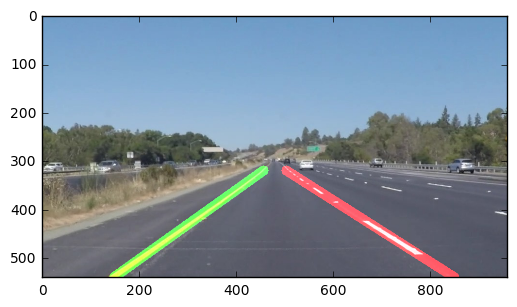

In [261]:
#Import packages
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
 #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


#GRAYSCALE & NOISE FILTERING
    #Function begins with taking the input image and converting it to grayscale 
kernel_size = 5 #Set kernel size for Gaussian smoothing; Must be an odd number (3, 5, 7...)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) #Conversion to grayscale
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0) #Gaussian smoothing function 


#EDGE DETECTION
    # After 'flattening' the RGB image into grayscale and reducing noise, use the Canny function to detect edges. 
# Threshold parameters for Canny edge detection:
low_threshold = 10
high_threshold = 100
edges = cv2.Canny(blur_gray, low_threshold, high_threshold) # Returns an image of contours/edges

#MASKING
    # We now need to create a mask to define an area of where the lane is in the image. 
    # Ideally, this would be a dynamic mask, but for the purposes of this lesson, we create a static mask. 
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

    # We use cv2.fillPoly() to remove the regions where the lane cannot be by defining a four-sided mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 315), (500, 315), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color) # Fills verticies in the empty mask with a polygon
masked_edges = cv2.bitwise_and(edges, mask) # Processes the Edges image and removes pixels outside the mask



#HOUGH TRANSFORM
    # Performing the hough transform will allow us to find pixels that are roughly congregated along in lines  

# Hough transform parameters
rho = 1 # Distance resolution in pixels of the Hough grid
theta = np.pi/180 # Angular resolution in radians of the Hough grid
threshold = 15 # Minimum number of votes (intersections in Hough grid cell)
min_line_length = 120 # minimum number of pixels making up a line
max_line_gap = 150    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on


# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)


# Iterate over the output "lines" and draw lines on a blank image
left_lane = []
right_lane = []

for line in lines:
    for x1,y1,x2,y2 in line:
        m_i = (y2-y1)/(x2-x1)
        if (m_i < 0):
            left_lane.append([x1, y1, x2, y2])
        else:
            right_lane.append([x1, y1, x2, y2])
            
left = np.mean(left_lane,axis=0).astype(int)
right = np.mean(right_lane,axis=0).astype(int)

m1 = (left[3]-left[1])/(left[2]-left[0])
b1 = left[1]-(m1*left[0])

m2 = (right[3]-right[1])/(right[2]-right[0])
b2 = right[1]-(m2*right[0])

y_min = 0 #image.shape[0]
xL1_max = ((y_max - b1) / m1).astype(int)
xL2_max = ((320-b1)/m1).astype(int)
xR1_max = ((y_max - b2) / m2).astype(int)
xR2_max = ((320-b2)/m2).astype(int)


cv2.line(line_image,(xL1_max,540),(xL2_max,320),(0,255,0),20)
cv2.line(line_image,(xR2_max,320),(xR1_max,540),(255,0,0),20)



# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 



# Draw the lines on the edge image
result = cv2.addWeighted(image, 1, line_image, .8, 0) 

plt.imshow(result)

print(right_lane)
#print(right)
#print(vertices[0,2,1])
#print(left_lane)
#print(lines)
#print(lines.mean(axis=0))
#print(lines[0][0][2])